Pontus Hultkrantz

# [September 2021 : Knight Moves 4](https://www.janestreet.com/puzzles/knight-moves-4-index/)

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.janestreet.com/puzzles/2021-09-01-knight-moves-4.png", width=500, height=500)

A knight was initially located in a square labeled 1. It then proceeded to make a series of moves, never re-visiting a square, and labeled the visited squares in order. When the knight was finished, the labeled squares in each region of connected squares1 had the same sum.

A short while later, many of the labels were erased. The remaining labels can be seen above.

Complete the grid by re-entering the missing labels.

The answer to this puzzle is the sum of the squares of the largest label in each row of the completed grid, as in the example.


[1]: E.g. the 14 and 33 are in different regions.

## Methodology

Backtracking, with bounds for possible max step.
Assuming a $N^2$ grid, with groups $i=1,...,g$, where group i has a current sum of $c_i$ with $r_i$ vacant positions. Let $n\leq N^2$ be the total number of steps in the solution, and let $s$ be the current maximum step on the board. Sum of all steps is then $S_n=\sum_{i=1}^n i = 0.5\cdot (1+n)\cdot n$ , and the sum per group is $G_n:=S_n/g$ which must be an integer.
We want ot find the possible values of $n$, especially the upper bound and group sum $\{m, G_m\}$.
- Max step must be divisible by number of groups.
- The current region sums must be less than or equal to $G_n$.
- Given the current maximum observed step $s$ on the board, $n\geq s$ and so $G_n \geq G_s$.
- The upper bound for each group sum is $c_i + n + (n-1) +... = c_i + r_i\cdot n - 0.5\cdot r_i\cdot(r_i-1)$
- If group sums are not equal having filled all steps below $s$, then if adding the current step to any group exceeds the upper bound value $G_m$, then current grid path is invalid.

##  Driver code

In [2]:
import numpy as np
import numba
    
@numba.njit
def add_coords(c1, c2):
    return [c1[0]+c2[0], c1[1]+c2[1]]
    
@numba.njit
def is_checkpoint(checkpoints, step):
    for i in range(len(checkpoints)):
        if checkpoints[i] == step:
            return True
    return False
    
@numba.njit
def valid_move(grid, checkpoints, step, move):
    if move[0] < 0 or move[0] >= grid.shape[0]:
        return False
    elif move[1] < 0 or move[1] >= grid.shape[1]:
        return False

    grid_node = grid[move[0], move[1]]

    if grid_node==0 and not is_checkpoint(checkpoints, step + 1):        
        return True
    elif grid_node == (step+1):
        return True
    else:
        return False

@numba.njit
def make_move(grid, step, move):
    step += 1
    grid[move[0], move[1]] = step
    return step
    
@numba.njit
def undo_move(grid, checkpoints, step, move):
    if not is_checkpoint(checkpoints, step):
        grid[move[0], move[1]] = 0
    return step-1 #cannot pass byref and modify
    
@numba.njit
def check_finished(grid, nregions, region, step, max_step_sum):
    count = np.zeros(nregions) # sum of values in regions
    regsize = np.zeros(nregions) # nbr blank fields in regions
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            count[region[i, j]] += grid[i, j]
            if grid[i, j] <= 0:
                regsize[region[i,j]] += 1
                
                
    h_max = np.max(count) # If check if all but the largest will surpas the theoretical maximum
    for i in range(len(count)):
        if count[i] < h_max:
            if count[i] + step >= max_step_sum[1]:
                return -1
            
    step_max = max_step_sum[0]
    min_ub = np.min(np.array([count[i] + regsize[i]*step_max -  0.5*regsize[i]*(regsize[i]-1) for i in range(len(count))]))
    max_lb = count.max()
    if min_ub < max_lb:
        return -1

    if np.all(count == count[0]): # If all regions same sum, we found solution.
        return 0
    else:
        return 1 # Continue steppinig

@numba.jit
def _solve_rec(pos, grid, checkpoints, step, nregions, region, max_step_sum):
    finish = check_finished(grid, nregions, region, step, max_step_sum)
    if finish == 0:
        return True
    elif finish == -1:
        return False
    
    deltas = [(r,c) for (r,c) in [(-2,-1),(-2,+1),(-1,-2),(-1,+2),(+1,-2),(+1,+2),(+2,-1),(+2,+1)]]
    for d in deltas:
        new_pos = np.array(add_coords(pos, d))
        if valid_move(grid, checkpoints, step, new_pos):
            step = make_move(grid, step, new_pos)
            if _solve_rec(new_pos, grid, checkpoints, step, nregions, region, max_step_sum):
                return True
            else:
                step = undo_move(grid, checkpoints, step, new_pos)
    return False
    
    
class Game:
    def __init__(self, grid, regions):
        self.grid = grid.copy()
        self.step, self.pos = self._find_start(grid)
        self.regions = regions.copy()
        self.nregions = regions.max() + 1
        self.bold_nodes = grid[grid!=0]
    
    def _find_start(self, grid):
        #step, coord = next((i,e) for (i,e) in enumerate(self.tape) if e)
        tmp = np.argwhere(grid==1)
        if len(tmp) == 0:
            raise ValueError("Start pos cound't be found")
        return 1, tmp[0]
        
    def _possible_max_steps(self):
        n_max_ub = self.grid.shape[0]*self.grid.shape[1]
        n_max_lb = self.grid.max()
        n_groups = self.nregions

        def tot_board_sum(n):
            return int((1+n)*n / 2)
        def group_sum(n_max):
            return int(0.5*(1+n_max)*n_max / n_groups)

        def divisible(n):
            return tot_board_sum(n) % n_groups == 0

        def get_group_stats():
            grp_sums = np.zeros(n_groups) # sum of values in regions
            grp_vacants = np.zeros(n_groups) # nbr blank fields in regions
            for i in range(self.grid.shape[0]):
                for j in range(self.grid.shape[1]):
                    grp_sums[self.regions[i, j]] += self.grid[i, j]
                    if self.grid[i, j] <= 0:
                        grp_vacants[self.regions[i,j]] += 1
            return grp_sums, grp_vacants

        all_comb = [i for i in range(n_max_lb, n_max_ub+1)]
        grp_sums, grp_vacants = get_group_stats()

        def is_within_bounds(n_max):
            lb = grp_sums
            ub = np.zeros(n_groups)
            for i in range(len(grp_sums)):
                ub[i] = grp_sums[i] + grp_vacants[i]*n_max -  0.5*grp_vacants[i]*(grp_vacants[i]-1)
            min_ub = np.min(ub)
            max_lb = np.max(lb)
            return min_ub >= max_lb and max_lb <= group_sum(n_max) <= min_ub

        return [(i, group_sum(i)) for i in all_comb if divisible(i) and is_within_bounds(i)]
        
    def solve(self):
        max_steps = self._possible_max_steps()
        return _solve_rec(self.pos, self.grid, self.bold_nodes, self.step, self.nregions, self.regions, max_steps[-1])


## Code for plotting solution matrix

In [3]:
import numpy as np
from matplotlib import pyplot as plt
def plot_solution(initial_grid, solution_grid, regions, regcolor):
    n_rows, n_cols = initial_grid.shape
    colorgrid = np.zeros(shape=(regions.shape[0], regions.shape[1], 3), dtype=int)
    # region number to color code
    #regcolor = {'y':[0, 11, 13, 12, 14, 15], 'p':[1, 2, 3, 4, 5], 'g':[9, 10, 11], 'b':[6, 7, 8, 16]}
    # color code to rgb
    colormap = {'y':(255,255,153), 'p':(255,224,246), 'g':(157,244,139), 'b':(167,232,255)}
    # Create N x N x 3 grid with rgb values
    for ccode,regs in regcolor.items():
        rgb = colormap[ccode]
        for r in regs:
            q = np.where(regions==r)
            colorgrid[q[0], q[1]] = rgb

    fig, ax = plt.subplots(1,1, figsize=(6, 6))
    ax.imshow(colorgrid)

    # Edge lines
    ax.hlines(y=np.arange(0, n_cols)+0.5, xmin=np.full(n_rows, 0)-0.5, xmax=np.full(n_cols, n_cols)-0.5, color="black", lw=0.5)
    ax.vlines(x=np.arange(0, n_cols)+0.5, ymin=np.full(n_rows, 0)-0.5, ymax=np.full(n_rows, n_rows)-0.5, color="black", lw=0.5)

    # Solition numbers.
    for i in range(colorgrid.shape[0]):
        for j in range(colorgrid.shape[1]):
            if initial_grid[i, j] != 0:
                ax.text(j, i, solution_grid[i, j], ha="center", va="center", color="k", fontsize=16, weight='bold')
            elif solution_grid[i, j] != 0:
                ax.text(j, i, solution_grid[i, j], ha="center", va="center", color="k", fontsize=16)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.show()
    row_max = solution_grid.max(axis=1)
    s = f"{'+'.join(f'{s}²' for s in row_max)} = {(row_max**2).sum()}"
    print(s)

## Example Grid

Wall time: 0 ns


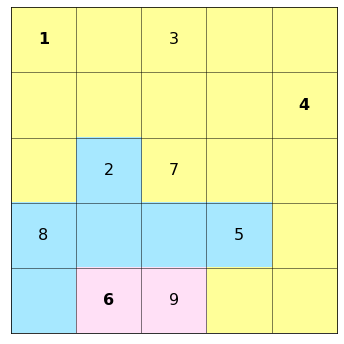

3²+4²+7²+8²+9² = 219


In [4]:
import numpy as np

ex_grid = np.array(
    [
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 4],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 6, 0, 0, 0]
    ])
ex_regions = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 2, 2, 0, 0]
    ])
regcolor = {'y':[0], 'p':[2], 'g':[], 'b':[1]}

gg = Game(ex_grid, ex_regions)
_ = gg.solve() # precompile
%time succ = gg.solve()
if succ:
    plot_solution(ex_grid, gg.grid, ex_regions, regcolor)

## Main grid

Wall time: 621 ms


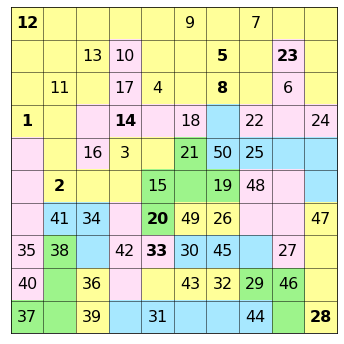

12²+23²+17²+24²+50²+48²+49²+45²+46²+44² = 14820


In [5]:
def get_large_inp():
    grid = np.array(
        [
            [12,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  5,  0, 23,  0],
            [ 0,  0,  0,  0,  0,  0,  8,  0,  0,  0],
            [ 0,  0,  0, 14,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  0, 20,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  0, 33,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 28]])
    regions = np.array(
        [
            [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 0,  0,  0,  1,  0,  0,  0,  0,  2,  0],
            [ 0,  0,  0,  1,  0,  0,  0,  0,  2,  0],
            [ 0,  0,  1,  1,  1,  1,  6,  2,  2,  2],
            [ 5,  0,  1,  0,  0,  9,  6,  6,  6,  6],
            [ 5,  0,  0,  0,  9,  9,  9,  3,  3,  6],
            [ 5,  8,  8,  4,  9, 12, 12,  3,  3, 14],
            [ 5, 11,  8,  4,  4, 16, 16, 16,  3, 14],
            [ 5, 11, 15,  4, 13, 13, 13, 10, 10, 14],
            [11, 11, 15,  7,  7,  7,  7,  7, 10, 14]])
    regcolor = {'y':[0, 11, 13, 12, 14, 15], 'p':[1, 2, 3, 4, 5], 'g':[9, 10, 11], 'b':[6, 7, 8, 16]}
    return grid, regions, regcolor

grid, regions, regcolor = get_large_inp()

start_pos = [(3,0), (3,2), (4,3), (6,3), (7,0), (7,2)]
for x,y in start_pos:
    grid, regions, regcolor = get_large_inp()
    grid[x,y]=1
    gg = Game(grid, regions)
    %time succ = gg.solve()
    if succ:
        plot_solution(grid, gg.grid, regions, regcolor)
        break